<a href="https://colab.research.google.com/github/AleCongi/Esame-ICON-/blob/main/ALMOSTDONE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ingegneria della Conoscenza
Università degli studi di Bari "Aldo Moro", Dipartimento di Informatica.

Il seguente notebook è stato elaborato degli studenti:


*   Congedo Alessandro (mat. 677315)
*   Romano Andrea (mat. XXXXXX)

Il progetto che presentiamo è un esempio di come l'IA possa essere utilizzata per classificare eventi in base a descrizioni e categorie.

---



L'obiettivo di questo studio è quello di sviluppare un sistema di apprendimento automatico che sia in grado di rappresentare la conoscenza sia a basso livello che ad alto livello, garantendo una gestione d'incertezza.

Il progetto è stato condotto nell'ottica di arricchire il precedente lavoro dei [**BroUsers**](https://www.instagram.com/bro__users) chiamato [**OneNight**](https://t.me/wannight_bot), un **bot Telegram** che raccoglie informazioni sugli eventi in una determinata zona geografica.

---
L'esigenza di una filtrazione ulteriore degli eventi mediante delle categorie prestabilite si configura come una nuova espansione del progetto.

La passione che abbiamo per il nostro lavoro, sia quello sviluppato in passato che quello presentato, ci ha spinto a esplorare nuove soluzioni e a sviluppare un sistema che possa fornire un contributo significativo alla comunità.

**Indice delle sezioni:**


*   **A**: *CARICAMENTO E FIX DEL DATASET*
  * **A1**: *PLOT DEL DATASET*
*   **B**: *PREPROCESS DELLE DESCRIZIONI*
  * **B1**: *FUNZIONI PREPROCESSING*
  * **B2**: *PREPROCESSING*
  * **B3**: *TOKENIZATION, SEQUENCING & PADDING*
  * **B4**: *RAPPRESENTAZIONE DEL TESTO A BASSO LIVELLO*
      * **B4.1** *ALTERNATIVA EMBEDDINGS VIA WORLD2VEC*
      * **B4.2** *ALTERNATIVA FEATURE EXTRACTION VIA RETE NEURALE*
      * **B4.3** *ALTERNATIVA VECTORIZATION VIA TERM FREQUENCY - INVERSE DOCUMENT FREQUENCY*
*   **C**: *CLASSIFICAZIONE*
*   **D**: *RETE NEURALE*
*   **E**: *LOGICHE FUZZY*
*   **F**: *RAPPRESENTAZIONE DELLA CONOSCENZA*
  * **F1**: *ONTOLOGIA: WORDNET*
  * **F2**: *RETE SEMANTICA*



In [1]:
!pip install nltk
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 1.9 MB/s eta 0:00:00


In [2]:
import numpy as np
from numpy.ma.core import outer
import pandas as pd
import seaborn as sns
from re import sub as sub
from sys import exit as exit
import matplotlib.pyplot as plt
import string

from nltk import pos_tag

import networkx as nx

from sklearn.metrics.pairwise import cosine_similarity

import sys

from wordcloud import WordCloud

from sklearn.metrics import pairwise_distances
from operator import pos

from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download as dl
from nltk import word_tokenize as tkn


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.naive_bayes import GaussianNB,BernoulliNB,CategoricalNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


#Metrics
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, hamming_loss, label_ranking_average_precision_score, precision_recall_curve, recall_score, classification_report, r2_score

#Multilable
from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset
from skmultilearn.ensemble import RakelD, RakelO, LabelSpacePartitioningClassifier
from skmultilearn.adapt import MLkNN

dl('wordnet')
dl('omw-1.4')
dl('punkt')
dl('stopwords')
dl('averaged_perceptron_tagger')

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Mounted at /content/drive


##**A**: *CARICAMENTO E FIX DEL DATASET*

In [10]:
tot=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/eventi.csv')
tot.head(10)

,culture,music,food,fun,id,text
0,0,0,0,1,1000187186721956,Martedi 05 gennaio super tombolata al Barfly!\...
1,0,1,0,1,100731190460200,"Ingresso free senza obbligo di consumazione,se..."
2,1,1,0,1,1014507045355357,"Giovedi 8 Marzo, Napulitanata ""celebra la donn..."
3,1,1,0,1,1015563648832823,yn e lieta di presentare\n\nNapoolyn x Resilie...
4,0,0,0,1,1021806692027608,Serata live \nVENERDI' 18 MARZO \nUn piacevole...
5,1,1,1,1,1023358881203820,Quest'anno in occasione di san Valentino il ri...
6,1,1,0,1,103006560538403,La 1 Esposizione dei disegni di DIPSTER accomp...
7,1,1,0,1,1033389857374299,LELIO MORRA e tornato a suonare in giro\n\nha ...
8,1,0,0,1,1033660330389424,Largo alla beneficenza! Per iniziare al megli...
9,1,1,0,1,1034778187923694,L'evento piu internazionale a Napoli! L Aperil...


In [11]:
tot.count()

culture    6870
music      6870
food       6870
fun        6870
id         6870
text       6870
dtype: int64

È chiaro che ci siano dei testi nulli. È possibile che siano eventi senza descrizione. Me ne accerto:

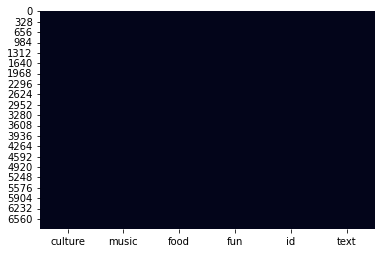

In [12]:
sns.heatmap(tot.isna(), cbar=False)

Sapendo che "id" è la nostra colonna primaria, controllo che il numero di valori unici nella colonna primaria sia uguale al numero di righe. Questo mi permette di accertarmi di non avere la stessa riga per più di una volta nel mio dataset.

In [13]:
tot['id'].nunique() == len(tot['id'])

False

In [14]:
tot = tot.drop_duplicates(subset="id", keep='last')
tot = tot.drop_duplicates(subset="text", keep='last')

for index, row in tot.iterrows():  
  try:
    trashId = row['id']
    trash = row['text'].lower()
  except AttributeError as ae:
    tot.drop(tot[tot['id'] == trashId].index, inplace=True)


In [15]:
tot['id'].nunique() == len(tot['id'])

True

In [ ]:
#tot.drop('isOpen',inplace=True,axis=1)

In [16]:
tot=tot.reset_index(drop=True)

In [17]:
tot.count()

culture    6053
music      6053
food       6053
fun        6053
id         6053
text       6053
dtype: int64

In [19]:
print(tot['text'][200])
print(tot['food'][200])
print(tot['fun'][200])
print(tot['music'][200])
print(tot['culture'][200])

CACTUS club presents * NATALE a 90 *
IL PARTY DANCE DI NATALE
DOMENICA 25 DICEMBRE 22:00 / 04:00
SPECIAL DJ SET SORRENTINO
dance '90 / 2000
dance love sex & panettone !
Indirizzo: Via Leopoldo Rodino' 8
Piazza Portanova - Napoli
info: +39 320 199 4834
https://www.cactusnapoli.it
https://www.instagram.com/cactus_napoli
https://www.facebook.com/cactusnapoli
0
1
1
1


###**A1**: *PLOT DEL DATASET*

Ecco i primi elementi del dataset.

In [20]:
tot.head()

,culture,music,food,fun,id,text
0,0,0,0,1,1000187186721956,Martedi 05 gennaio super tombolata al Barfly!\...
1,0,1,0,1,100731190460200,"Ingresso free senza obbligo di consumazione,se..."
2,1,1,0,1,1014507045355357,"Giovedi 8 Marzo, Napulitanata ""celebra la donn..."
3,1,1,0,1,1015563648832823,yn e lieta di presentare\n\nNapoolyn x Resilie...
4,0,0,0,1,1021806692027608,Serata live \nVENERDI' 18 MARZO \nUn piacevole...


In [21]:
tot.dtypes

culture     int64
music       int64
food        int64
fun         int64
id          int64
text       object
dtype: object

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


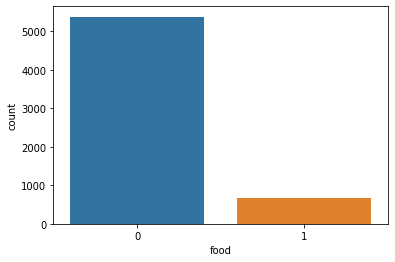

In [26]:
sns.countplot(tot['food'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


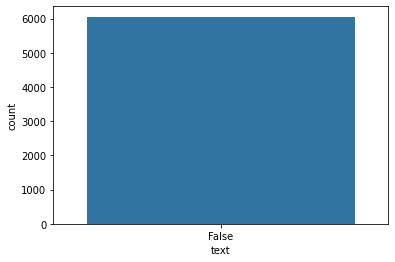

In [23]:
sns.countplot((tot["text"] == None))

##**B**: *PREPROCESS DELLE DESCRIZIONI*

###**B1**: *FUNZIONI PREPROCESSING*

In [28]:
def remove_numbers(input_string):
    # Crea una tabella di traduzione che mappa tutti i numeri a None
    translate_table = input_string.maketrans("", "", string.digits)
    # Utilizza la tabella di traduzione per rimuovere tutti i numeri
    return input_string.translate(translate_table)

def remove_punctuation(input_string):
    for char in string.punctuation:
          input_string = input_string.replace(char, " ")
    return input_string

def preProcessDescription(description,tokenizer,stopwordsTotali,maxSeqLen):
  words = remove_punctuation(remove_numbers(description.lower())).split()

  parole_filtrate = [parola for parola in words if not parola in stopwordsTotali]
 
  descrizione_filtrata = " ".join(parole_filtrate)
  print(descrizione_filtrata)
  # convert the text to a numerical representation
  input_data = tokenizer.texts_to_sequences([descrizione_filtrata])
  input_data = pad_sequences(input_data, maxlen=maxSeqLen,padding='post')
  original_description = ""
  for i, word in enumerate(input_data[0]):
    if word == 1:
      for key, value in tokenizer.word_index.items():
        if value == i :
          original_description += key + " "
  print('Traduzione della sequenza numero in parole: ')
  print(original_description)
  return input_data

Wordnet Ontology Functions

In [29]:
#Wordnet

def get_syns(description):
  test=[]
  words = tkn(description)
  for every in words:
    if (every not in stopwordsTotali):
      if(wn.synsets(every, lang ='ita') == []):
        
          test.append(wn.synsets(every))
      else:
        
          test.append(wn.synsets(every, lang ='ita'))
      #print('parola iniziale: ',every)
      #print('synset: ',wn.synsets(every, lang ='ita'))
  lemmatizer = WordNetLemmatizer()
  out =[]
  for each in range(len(test)):
    for q in range(len(test[each])):
      wordToAdd=lemmatizer.lemmatize(test[each][q].name().split('.')[0])
      out.append(wordToAdd)
      if(q==1):
        #print(out)
        break
  #out=test
  out=list(set(out))
  return out

def reduced_description(description):
    # Tokenize the description
    tokens = tkn(description)
    # Reduce the words to their most common synset
    reduced_description = []
    for token in tokens:
      try:
          synset = wn.synsets(token, lang='ita',pos=wn.NOUN)
         
          
          lemma = max(synset[0].lemmas(), key=lambda x: x.count()).name()
          reduced_description.append(lemma)
      except:
        try:
          synset = wn.synsets(token, lang='ita',pos=wn.VERB)
          lemma = max(synset[0].lemmas(), key=lambda x: x.count()).name()
          reduced_description.append(lemma)
        except:
          try:
            synset = wn.synsets(token, lang='eng',pos=wn.NOUN)
            lemma = max(synset[0].lemmas(), key=lambda x: x.count()).name()
            reduced_description.append(lemma)
          except:
            try:
                synset = wn.synsets(token, lang='eng',pos=wn.VERB)
                lemma = max(synset[0].lemmas(), key=lambda x: x.count()).name()
                reduced_description.append(lemma)
            except:
    
                continue
   
    return list(set(reduced_description))


def predict_closest_clusters(df, description, km, X, vectorizerTfIdf):

    description=get_syns(description)

    newWords = ''
    
    for each in description:
      newWords = newWords + ' ' + each
    description=newWords

    # Transform the input description into a tf-idf representation
    input_tfidf = vectorizerTfIdf.transform([description])

    # Calculate the distances between the input and each of the 10 clusters
    cluster_distances = km.transform(input_tfidf).flatten()

    # Get the index of the closest cluster
    closest_cluster_index = np.argmin(cluster_distances)

    print("Il cluster più vicino è il cluster numero: ", closest_cluster_index)

    terms = vectorizerTfIdf.get_feature_names()
    top_ten_words = [terms[ind] for ind in order_centroids[closest_cluster_index, :5]]
    print("Le sue parole più rilevanti sono: {}".format(', '.join(top_ten_words)))
    
    # Calculate the distances between the input and each sample in X
    sample_distances = pairwise_distances(input_tfidf, X).flatten()
    # Get the indices of the 5 closest samples
    closest_sample_indices = sample_distances.argsort()
    print("I 5 eventi più importanti nel dataset sono:")
    count = 0
    for i in closest_sample_indices: 
      if (len(df['text'][i]) > 100):
        print(df['text'][i])
        count = count + 1
      if (count == 5):
        break

###**B2**: *PREPROCESSING*

In [30]:
stp = open("/content/drive/MyDrive/Colab Notebooks/stopwordsita.txt", "r")
data = stp.read().split("\n")
stp.close()
stopwordsTotali = stopwords.words('italian') + stopwords.words('english') + data
stopwordsTotali = list(set(stopwordsTotali))

In [31]:
descrizioni_filtrate = []
for index, descrizione in tot.iterrows():
  parole = tkn(remove_punctuation(remove_numbers(str(descrizione['text']).lower())))
  parole_filtrate = [parola for parola in parole if not parola in stopwordsTotali]
  descrizione_filtrata = " ".join(parole_filtrate)
  descrizioni_filtrate.append(descrizione_filtrata)

In [32]:
descrizioni_filtrate[0]

'super tombolata barfly tante calze vincere formula panino patatine bibita cartella offriamo consigliata prenotazione'

In [33]:
tot['text'][0]

'Martedi 05 gennaio super tombolata al Barfly!\nTante calze da vincere!!!\nFormula 10 euro panino patatine e bibita e la cartella la offriamo noi!\nConsigliata la prenotazione\n081660023'

In [34]:
corpus = descrizioni_filtrate

In [35]:
type(corpus)

list

In [36]:
print(len(tot['text']) == len(corpus))

True


In [37]:
tot['filtered_desc']=corpus

In [38]:
X1 = []
newText=corpus

for description in newText:   
    feature =[]
    features = reduced_description(str(description))
    words = ''
    for each in features:
      words = words + ' ' + each
    X1.append(words)

In [39]:
tot['wordnet_desc']=X1

In [40]:
inx=7
print(corpus[inx])
print(X1[inx])

beneficenza iniziare meglio anno scolastico centro birreria supporta associazioni miano protagonista diamounamano ultras raccolto tantissimi giocattoli verranno regalati famiglie bambini bisogno poter richiedere coupon ritirare giocattoli contattare associazione miano protagonista mail mianoprotagonista libero direttamente presso sede lazio
 grade toddler motive reach crop hide headquarters alehouse association mail require freeman Latium begin hit coupon charity protagonist


In [41]:
tot

,culture,music,food,fun,id,text,filtered_desc,wordnet_desc
0,0,0,0,1,1000187186721956,Martedi 05 gennaio super tombolata al Barfly!\...,super tombolata barfly tante calze vincere for...,briefcase rule win bun superintendent booking...
1,0,1,0,1,100731190460200,"Ingresso free senza obbligo di consumazione,se...",ingresso free obbligo consumazione serata disc...,entrance responsibility bar discus free eveni...
2,1,1,0,1,1014507045355357,"Giovedi 8 Marzo, Napulitanata ""celebra la donn...",napulitanata celebra donna serata eccezione ma...,level museum trick arcade evening result porc...
3,1,1,0,1,1015563648832823,yn e lieta di presentare\n\nNapoolyn x Resilie...,yn lieta presentare napoolyn x resilienza reco...,propaganda allow single project producer refl...
4,0,0,0,1,1021806692027608,Serata live \nVENERDI' 18 MARZO \nUn piacevole...,serata live piacevole ritorno palco biergrube ...,auction_block wallop evening passion group Lo...
...,...,...,...,...,...,...,...,...
6048,1,1,0,0,996956944037551,Hot Club Roma Trio\n\nMoreno Viglione chitarra...,hot club trio moreno viglione chitarra solista...,project jazz trio double_bass group first whi...
6049,1,0,0,0,997255064998935,"Presentazione del libro:\n ""Tasmania"" (Einaudi...",presentazione libro tasmania einaudi editore p...,feeling novel contemporary leak check future ...
6050,1,1,0,0,997824980996408,In occasione delle GIORNATE EUROPEE DEL PATRIM...,occasione giornate europee patrimonio ore muse...,park concert museum cello uracil ore backgrou...
6051,1,0,0,1,998364400508276,Vieni a Danzare gratuitamente per un giorno co...,vieni danzare gratuitamente giorno amici tagga...,dance day acting morning headquarters contemp...


###**B3**: *TOKENIZATION, SEQUENCING & PADDING*

In [42]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_NB_WORDS = 30000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
seq_lens = [len(s) for s in sequences]

In [43]:
sampleIndex = 1998
print('Sequenza parola numero %s: ' % sampleIndex)
for x in sequences[sampleIndex]:
  print('%d,' % x, end =' ')

Sequenza parola numero 1998: 
10855, 780, 91, 3, 45, 1, 5768, 249, 10108, 12430, 14725, 2298, 1354, 3656, 614, 598, 9385, 323, 12431, 1794, 23826, 598, 9385, 1535, 700, 23827, 59, 314, 142, 1767, 614, 5588, 330, 73, 330, 515, 339, 2462, 140, 710, 10108, 2170, 201, 540, 227, 8430, 787, 12430, 14725, 8477, 24, 97, 84, 6026, 42, 1005, 929, 7297, 110, 3053, 377, 18, 6, 27, 110, 869, 10619, 24, 3986, 94, 106, 18, 1960, 402, 4589, 1236, 488, 1206, 2190, 14726, 2165, 2359, 4816, 731, 23828, 12432, 1146, 2122, 222, 222, 118, 4242, 8700, 95, 612, 10689, 1720, 599, 1984, 899, 1328, 14725, 10501, 201, 3159, 21315, 16970, 1776, 12433, 368, 16003, 3258, 3172, 10856, 18138, 1404, 95, 726, 467, 23829, 736, 43, 927, 78, 11427, 12434, 562, 2857, 1191, 853, 122, 5873, 855, 6681, 598, 9385, 4237, 1279, 320, 3474, 7641, 2249, 7600, 5329, 84, 612, 2344, 4141, 323, 12431, 1794, 23826, 598, 9385, 201, 7440, 4589, 2249, 6766, 201, 18139, 13520, 4703, 4210, 14727, 700, 23827, 9526, 16520, 21281, 1639, 13154, 4

In [44]:
print('Traduzione della sequenza numero %d in parole: ' % sampleIndex)
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())
" ".join([index_to_word[i] for i in sequences[sampleIndex]])

Traduzione della sequenza numero 1998 in parole: 


'langelo castello danza musica spettacolo ore cortile alessandro tradimenti harold pinter traduzione alessandra serra regia michele sinisi stefano braschi stefania medri michele sinisi scene federico biancalani collaborazione artistica francesco aiuto regia nicolo produzione centro produzione teatrale contributo next laboratorio idee tradimenti messa scena opera premio nobel letteratura harold pinter presento prima volta pubblico londinese storia relazione pero ritroso fine esordi inizia due anni dopo fine rapporto termina prima esso inizio oltre due amanti ce marito nonche migliore amico insomma triangolo effetti trama apparentemente semplice lineare susseguirsi fatti lascia piano piano spazio complessita danimo tre personaggi accomunati segreto volte difficile portare testo pinter rivive scena allestimento sanguigno asciutto tratti violento parole dette pensieri azioni nascoste riempiono vite tre protagonisti spazi irrompono forza tutte relazioni proprio tensione silenzi cio poteva d

Text(0.5, 1.0, 'Y documenti con X parole')

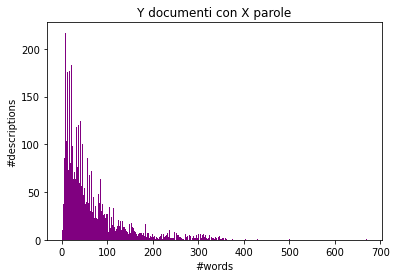

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=500, color = 'purple')
plt.xlabel('#words')
plt.ylabel('#descriptions')
plt.title('Y documenti con X parole')

In [46]:
media=np.mean(seq_lens)
print("average length: %0.1f" % media)
print("max length: %d" % max(seq_lens))
y = 0
for i in seq_lens:
  if i < media:
    y = y + 1

print("percentuale descrizioni di lunghezza inferiore ad average length: %d%%" % (int(y*100/len(seq_lens))))


average length: 67.1
max length: 670
percentuale descrizioni di lunghezza inferiore ad average length: 66%


La lunghezza media dei testi è di circa 65: eseguo il pad con massima lunghezza 70, valutando che la maggior parte delle descrizioni non supera quel numero di parole.

In [47]:
MAX_SEQUENCE_LENGTH = 70

# pad sequences with 0s
padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

print('Shape of data tensor:', padded.shape)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Shape of data tensor: (6053, 70)
Found 55964 unique tokens.


In [48]:
padded[sampleIndex].shape[0]

70

In [49]:
preProcessDescription('techno rave party festa scuola',tokenizer,stopwordsTotali, MAX_SEQUENCE_LENGTH)

techno rave party festa scuola
Traduzione della sequenza numero in parole: 



array([[1301, 7544,  115,   87,  138,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]], dtype=int32)

###**B4**: *RAPPRESENTAZIONE DEL TESTO A BASSO LIVELLO*

####**B4.1**: *ALTERNATIVA EMBEDDINGS VIA WORLD2VEC*


In [50]:
import gensim.downloader as api

# Download the models (1660MB)
word2vec_model300 = api.load('word2vec-google-news-300')

[=================================================-] 99.9% 1661.1/1662.8MB downloaded


In [52]:
word2vec_model300.save("/content/drive/MyDrive/Colab Notebooks/word2vec.bin")

In [55]:
'''
x_emb = []
for sentence in padded:
  print('sentence')
  print(sentence)
  sent_emb = [0 for k in range(300)] 
  
  num_tok = 0
  for tok in sentence:
    if tok != 0:
      word=list(word_index.keys())[list(word_index.values()).index(tok)]
      print('word: '+ word)
      try:
          emb = word2vec_model300.wv[word]
          sent_emb = [x + y for x, y in zip(sent_emb, emb)]
          num_tok = num_tok +1
      except:
          pass
  if num_tok != 0:
    final_sent_emb = [x / num_tok for x in sent_emb]         
  x_emb.append(final_sent_emb)
  

x_emb = np.array(x_emb)
with open('/content/drive/MyDrive/Colab Notebooks/embeddings.npy', 'wb') as f:
    np.save(f, x_emb)
'''
with open('/content/drive/MyDrive/Colab Notebooks/embeddings.npy', 'rb') as f:
    x_emb = np.load(f)
print(type(x_emb))
print(x_emb.shape)


<class 'numpy.ndarray'>
(6053, 300)


In [56]:
x_emb.shape

(6053, 300)

In [57]:
print(x_emb[sampleIndex])

[ 0.00419922 -0.00130959  0.02103206  0.08089425 -0.00661621  0.04336112
  0.04568045 -0.07013375  0.01910924  0.06270752 -0.0645037  -0.09502128
 -0.12526507  0.02397156 -0.05121416  0.09546836  0.08652344  0.10049526
  0.00252359  0.02311271 -0.01206055  0.00401088  0.07006313  0.04632917
 -0.12335728 -0.07523237 -0.02168579  0.10066942 -0.0265201  -0.056427
 -0.00749283  0.02717002 -0.01224452 -0.04206369 -0.06250262 -0.05702738
 -0.01557225  0.04326957  0.04025443 -0.03584682 -0.02177647 -0.03693521
  0.10750558  0.06237139  0.00891462 -0.11394523 -0.06996286  0.00519758
 -0.02910505  0.05909249 -0.1376988   0.12144775  0.05811593 -0.00666722
 -0.02965001  0.10903146 -0.08820626 -0.09533822  0.01781398 -0.06845703
 -0.06104562  0.05198364 -0.05387235 -0.07949393  0.02793427 -0.1241769
 -0.0535226  -0.06434599  0.05667964  0.12916434  0.04739772  0.01855469
  0.01134535  0.02771427 -0.07660784 -0.02441145  0.04935041 -0.01581944
 -0.02481319 -0.0085641   0.00641741 -0.02090628 -0.00

####**B4.2**: *ALTERNATIVA FEATURE EXTRACTION VIA RETE NEURALE*

In [61]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten

embedding_size = 100

# Creare la rete neurale feed-forward
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_size, input_length=MAX_SEQUENCE_LENGTH))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Creare la matrice di vettorizzazione delle descrizioni degli eventi
#POTREI PROVARE CON "CORPUS" AL POSTO DI PADDINGS
token_matrix = model.predict(padded)

190/190 [==============================] - 1s 3ms/step


####**B4.3**: *ALTERNATIVA VECTORIZATION VIA TERM FREQUENCY - INVERSE DOCUMENT FREQUENCY*

In [58]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(corpus)

##**C**: *CLASSIFICAZIONE*

In [60]:
y = tot[['culture', 'music', 'food', 'fun']]

####Split

In [62]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [63]:
X_trainEmb,X_testEmb,y_trainEmb,y_testEmb = train_test_split(x_emb,y,test_size=0.25,random_state=42)

In [64]:
X_trainTM,X_testTM,y_trainTM,y_testTM = train_test_split(token_matrix,y,test_size=0.25,random_state=42)

###Pesi

In [68]:
from sklearn.utils import class_weight
weights = class_weight.compute_sample_weight(class_weight="balanced", y=y_train)
weightsEmb = class_weight.compute_sample_weight(class_weight="balanced", y=y_trainEmb)
weightsTM = class_weight.compute_sample_weight(class_weight="balanced", y=y_trainTM)

In [71]:
print(weights==weightsEmb)
print(weightsEmb==weightsTM)

[ True  True  True ...  True  True  True]
[ True  True  True ...  True  True  True]


In [ ]:
from sklearn.decomposition import PCA
pca = PCA (170)

reduced = pca.fit_transform(x_emb)

X_reduced,X_testReduced,y_trainReduced,y_testReduced = train_test_split(reduced,y,test_size=0.25,random_state=42)
reduced.shape

(6327, 170)

###Classificazione

In [114]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput  import  ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

Ora utilizzeremo la tecnica di classificazione a multipli riferimenti (OneVsRest) in quanto il nostro dataset risulta sbilanciato. È buona norma utilizzare questo tipo di classificazione sui dataset sbilanciati perché si addestra un classificatore per ogni classe: ogni classificatore è responsabile della distinzione tra la sua classe specifica e tutte le altre (appunto One vs Rest). Questo significa che ogni classificatore può concentrarsi sulle proprietà distintive della classe stessa

In [118]:
classificatori = [OneVsRestClassifier, ClassifierChain, LabelPowerset]
estimatori =[DecisionTreeClassifier(),RandomForestClassifier(), SVC()]
param_grid = {
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_depth': [None, 5, 10],
    'estimator__min_samples_split': [2, 10],
    'estimator__min_samples_leaf': [1, 4]
}

In [122]:
def atlas (estimatori, classificatori, x_train, x_test, y_train, y_test, parametri = None):
  results = []
  for ml in classificatori:
    for each in estimatori:
      clf = ml(each)
      if (parametri is None):
          clf.fit(x_train, y_train)
          y_pred = clf.predict(x_test)
      else:
        try:
          grid_search = GridSearchCV(clf, parametri, cv=5, scoring='accuracy')
          grid_search.fit(x_train, y_train)
          best_clf = grid_search.best_estimator_
          y_pred = best_clf.predict(x_test)
        except:
          clf.fit(x_train, y_train)
          y_pred = clf.predict(x_test)
      print('\n\n')
      print(str(ml) + ' con ' + str(each) + ':\n\n')
      print('Accuracy: %0.5f' % accuracy_score(y_test,y_pred))
      print('Loss di hamming: %0.5f' % hamming_loss(y_test,y_pred))
      print('Label ranking Average-Precision: %0.5f' % label_ranking_average_precision_score(y_test,y_pred))
      results.append([str(ml), str(each), y_pred])
  return results

In [ ]:
print('Eseguo classificazione su vettori Tf-Idf\n')
risultatiTfIdf = atlas(estimatori, classificatori, X_train, X_test, y_train, y_test, param_grid)
print('Eseguo classificazione su matrice di token (feature Neural Network)\n')
risultatiNN = atlas(estimatori, classificatori, X_trainTM, X_testTM, y_trainTM, y_testTM, param_grid)
print('Eseguo classificazione su Embeddings (Word2Vec)\n')
risultatiEmb = atlas(estimatori, classificatori, X_trainEmb, X_testEmb, y_trainEmb, y_testEmb, param_grid)

####VariousPlots

DecisionTreeClassifier():



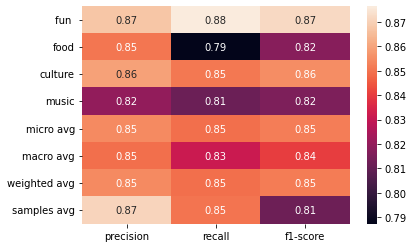

In [84]:
print(results[0][0] + ':\n')
sns.heatmap(pd.DataFrame(classification_report(y_test,results[0][1], zero_division=1, output_dict=True, target_names=['fun ', 'food', 'culture', 'music'])).iloc[:-1, :].T, annot=True, linecolor='purple')

RandomForestClassifier():



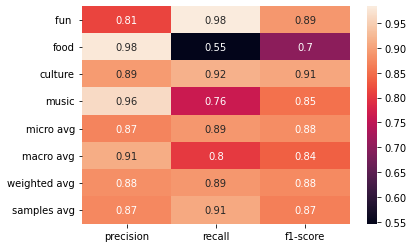

In [85]:
print(results[1][0] + ':\n')
sns.heatmap(pd.DataFrame(classification_report(y_test,results[1][1], zero_division=1, output_dict=True, target_names=['fun ', 'food', 'culture', 'music'])).iloc[:-1, :].T, annot=True, linecolor='purple')

KNeighborsClassifier():



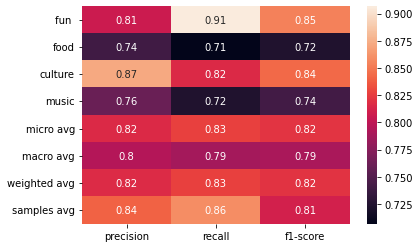

In [86]:
print(results[2][0] + ':\n')
sns.heatmap(pd.DataFrame(classification_report(y_test,results[2][1], zero_division=1, output_dict=True, target_names=['fun ', 'food', 'culture', 'music'])).iloc[:-1, :].T, annot=True, linecolor='purple')

LogisticRegression():



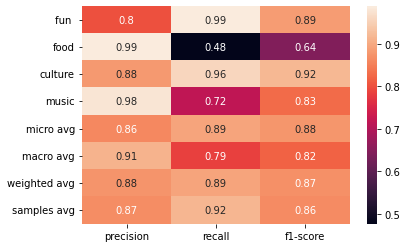

In [87]:
print(results[3][0] + ':\n')
sns.heatmap(pd.DataFrame(classification_report(y_test,results[3][1], zero_division=1, output_dict=True, target_names=['fun ', 'food', 'culture', 'music'])).iloc[:-1, :].T, annot=True, linecolor='purple')

SVC():



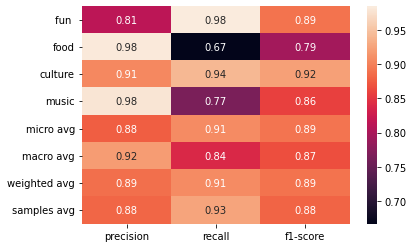

In [88]:
print(results[4][0] + ':\n')
sns.heatmap(pd.DataFrame(classification_report(y_test,results[4][1], zero_division=1, output_dict=True, target_names=['fun ', 'food', 'culture', 'music'])).iloc[:-1, :].T, annot=True, linecolor='purple')

###Logistic Regression (o che ne so mo vediamo) per trasformazione del dataset

In [126]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

test per trasformazione del dataset

In [127]:
target_variables = ["culture", "music", "food", "fun"]

# Fit a logistic regression model for each target variable
models = []
for target in target_variables:
    clf = LogisticRegression(random_state=0)
    clf.fit(X, tot[target])
    models.append(clf)

# Generate probability estimates for each target variable
probabilities = np.zeros((tot.shape[0], len(target_variables)))
for i, clf in enumerate(models):
    probabilities[:, i] = clf.predict_proba(vectorizer.fit_transform(tot["filtered_desc"]))[:, 1]

# Normalize the probabilities so that they sum up to 1 for each sample
probabilities /= probabilities.sum(axis=1, keepdims=True)

# Creare un nuovo dataset con le probabilità
new_df = pd.DataFrame(probabilities, columns=target_variables)

# Aggiungere le descrizioni come nuova colonna
new_df["filtered_desc"] = tot["filtered_desc"]
new_df["wordnet_desc"] = tot["wordnet_desc"]
new_df["text"] = tot["text"]
new_df["id"]=tot["id"].astype(str)
# Salvare il nuovo dataset
#new_df.to_csv("probabilities.csv", index=False)

In [128]:
new_df

,culture,music,food,fun,filtered_desc,wordnet_desc,text,id
0,0.207637,0.072232,0.075482,0.644649,super tombolata barfly tante calze vincere for...,briefcase rule win bun superintendent booking...,Martedi 05 gennaio super tombolata al Barfly!\...,1000187186721956
1,0.174214,0.384978,0.046762,0.394046,ingresso free obbligo consumazione serata disc...,entrance responsibility bar discus free eveni...,"Ingresso free senza obbligo di consumazione,se...",100731190460200
2,0.322403,0.298366,0.028590,0.350641,napulitanata celebra donna serata eccezione ma...,level museum trick arcade evening result porc...,"Giovedi 8 Marzo, Napulitanata ""celebra la donn...",1014507045355357
3,0.360383,0.320979,0.008198,0.310441,yn lieta presentare napoolyn x resilienza reco...,propaganda allow single project producer refl...,yn e lieta di presentare\n\nNapoolyn x Resilie...,1015563648832823
4,0.263686,0.208605,0.024446,0.503262,serata live piacevole ritorno palco biergrube ...,auction_block wallop evening passion group Lo...,Serata live \nVENERDI' 18 MARZO \nUn piacevole...,1021806692027608
...,...,...,...,...,...,...,...,...
6048,0.366929,0.398006,0.015413,0.219653,hot club trio moreno viglione chitarra solista...,project jazz trio double_bass group first whi...,Hot Club Roma Trio\n\nMoreno Viglione chitarra...,996956944037551
6049,0.635078,0.080165,0.020011,0.264746,presentazione libro tasmania einaudi editore p...,feeling novel contemporary leak check future ...,"Presentazione del libro:\n ""Tasmania"" (Einaudi...",997255064998935
6050,0.462070,0.341481,0.016241,0.180208,occasione giornate europee patrimonio ore muse...,park concert museum cello uracil ore backgrou...,In occasione delle GIORNATE EUROPEE DEL PATRIM...,997824980996408
6051,0.459574,0.072607,0.015819,0.452000,vieni danzare gratuitamente giorno amici tagga...,dance day acting morning headquarters contemp...,Vieni a Danzare gratuitamente per un giorno co...,998364400508276


In [129]:
tot

,culture,music,food,fun,id,text,filtered_desc,wordnet_desc
0,0,0,0,1,1000187186721956,Martedi 05 gennaio super tombolata al Barfly!\...,super tombolata barfly tante calze vincere for...,briefcase rule win bun superintendent booking...
1,0,1,0,1,100731190460200,"Ingresso free senza obbligo di consumazione,se...",ingresso free obbligo consumazione serata disc...,entrance responsibility bar discus free eveni...
2,1,1,0,1,1014507045355357,"Giovedi 8 Marzo, Napulitanata ""celebra la donn...",napulitanata celebra donna serata eccezione ma...,level museum trick arcade evening result porc...
3,1,1,0,1,1015563648832823,yn e lieta di presentare\n\nNapoolyn x Resilie...,yn lieta presentare napoolyn x resilienza reco...,propaganda allow single project producer refl...
4,0,0,0,1,1021806692027608,Serata live \nVENERDI' 18 MARZO \nUn piacevole...,serata live piacevole ritorno palco biergrube ...,auction_block wallop evening passion group Lo...
...,...,...,...,...,...,...,...,...
6048,1,1,0,0,996956944037551,Hot Club Roma Trio\n\nMoreno Viglione chitarra...,hot club trio moreno viglione chitarra solista...,project jazz trio double_bass group first whi...
6049,1,0,0,0,997255064998935,"Presentazione del libro:\n ""Tasmania"" (Einaudi...",presentazione libro tasmania einaudi editore p...,feeling novel contemporary leak check future ...
6050,1,1,0,0,997824980996408,In occasione delle GIORNATE EUROPEE DEL PATRIM...,occasione giornate europee patrimonio ore muse...,park concert museum cello uracil ore backgrou...
6051,1,0,0,1,998364400508276,Vieni a Danzare gratuitamente per un giorno co...,vieni danzare gratuitamente giorno amici tagga...,dance day acting morning headquarters contemp...


In [130]:
# Prevedi le etichette per un nuovo evento
new_event = ['Techno rave musica ballo amici alcohol']
X_new = vectorizer.transform(new_event)

y_pred_fun = models[0].predict_proba(X_new)[0][1]
y_pred_food = models[1].predict_proba(X_new)[0][1]
y_pred_culture = models[2].predict_proba(X_new)[0][1]
y_pred_music = models[3].predict_proba(X_new)[0][1]

# Confronta i risultati per evincere la categoria di appartenenza dell'evento
probs = [y_pred_fun, y_pred_food, y_pred_culture, y_pred_music]
pred_class = ['culture', 'music', 'food', 'fun'][np.argmax(probs)]
print(f"The new event belongs to the {pred_class} class with a probability of {np.max(probs):.2f}")

The new event belongs to the fun class with a probability of 0.86


##**D**: *RETE NEURALE*

In [ ]:
# mlp for multi-label classification
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt

# get the model
def get_model(n_inputs, n_outputs):
  model = Sequential()
  model.add(Dense(256, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(n_outputs, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
  return model

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X_train, y_train, X_test, y_test):
  results = list()
  # define evaluation procedure
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  model = get_model(X_train.shape[1], y_train.shape[1])
  # fit model
  fit=model.fit(X_train, y_train, verbose=1, epochs=50)
  # make a prediction on the test set
  yhat = model.predict(X_test)
    # calculate accuracy
  acc = accuracy_score(y_test.round(), yhat.round())
  # store result
  print('>%.3f' % acc)
  results.append(acc)
  print(yhat)
  return results,model

def build_model(modello,mlb_estimator,xtrain,ytrain,xtest,ytest):
  # Create an Instance
  clf = mlb_estimator(modello)
  clf.fit(xtrain,ytrain)
  # Predict
  clf_predictions = clf.predict(xtest)
  # Check For Accuracy
  acc = accuracy_score(ytest,clf_predictions)
  ham = hamming_loss(ytest,clf_predictions)
  result = {"accuracy:":acc,"hamming_score":ham}
  return result

In [ ]:
# evaluate model
results,model = evaluate_model(X_train, y_train, X_test, y_test)
# summarize performance
print('Accuracy: %.3f (%.3f)' % (mean(results), std(results)))

##**E**: *LOGICHE FUZZY*

Vogliamo tramite regole fuzzy determinare se un evento si svolgerà di notte o meno

In [ ]:
!pip install scikit-fuzzy
!pip install fuzzywuzzy
from skfuzzy import control as ctrl
from fuzzywuzzy import fuzz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 KB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894088 sha256=7117cd0a8a1f7c3cdab6230438404ba8305aa30a471189693e923651122c64a7
  Stored in directory: /root/.cache/pip/wheels/2c/04/80/7eefb1a2de7d36aefd06432fab2a1486caf0a0596a7067391a
Successfully built scikit-fuzzy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
def is_night_event(event_vector, night_vector, threshold=25):
  similarity = fuzz.token_set_ratio(event_vector, night_vector)
  if similarity >= threshold:
    return True
  else:
    return False

Deduco la costruzione della regola da delle stime probabilistiche effettuate sul dataset

In [ ]:
def categorize_text(df, string):
  words = string.split()
  result = [0, 0, 0, 0]
  count = 0
  for index, row in tot.iterrows():
    for word in words:
      if word in row['text']:
        result[0] = result[0] + row['fun']
        result[1] = result[1] + row['food']
        result[2] = result[2] + row['culture']
        result[3] = result[3] + row['music']
        count = count + 1
        break
  result[0] = result[0] / count
  result[1] = result[1] / count
  result[2] = result[2] / count
  result[3] = result[3] / count
  return result
#questi rappresentano i valori medi su cui definiremo la regola
valoriNotte=categorize_text(tot,'notte')
valoriNotte

[0.4, 0.32280701754385965, 0.8070175438596491, 0.5859649122807018]

estrae il vettore delle feature per quell'evento

In [ ]:
def get_event_vector(event_tuple):
    event_vector = []
    for header in ['fun', 'food', 'culture', 'music']:
        event_vector.append(event_tuple[header])
    return event_vector

In [ ]:
event_vector=get_event_vector(new_df.iloc[0])
event_vector

[0.3946944356706709,
 0.0648401976819875,
 0.4304247158436728,
 0.1100406508036688]

In [ ]:
result = is_night_event(event_vector, valoriNotte)
if result:
  print("L'evento è di notte")
else:
  print("L'evento non è di notte")

L'evento è di notte


In [ ]:
tag=[]
for index, row in new_df.iterrows():
    event_vector=get_event_vector(new_df.iloc[index])
    tag.append(is_night_event(event_vector, valoriNotte))

new_df['atNight'] = tag

In [ ]:
new_df

,fun,food,culture,isMusic,filtered_desc,wordnet_desc,text,id,isNight
0,0.394694,0.064840,0.430425,0.110041,super tombolata barfly tante calze vincere for...,superintendent booking bun soft_drink win rul...,Martedi 05 gennaio super tombolata al Barfly!\...,1000187186721956,True
1,0.215571,0.033047,0.390544,0.360837,ingresso free obbligo consumazione serata disc...,responsibility bar discus consummation entran...,"Ingresso free senza obbligo di consumazione,se...",100731190460200,False
2,0.113385,0.203644,0.281463,0.401508,napulitanata celebra donna serata eccezione ma...,Internationale lingerie 5 level reputation ar...,"Giovedi 8 Marzo, Napulitanata ""celebra la donn...",1014507045355357,True
3,0.032159,0.191603,0.306882,0.469356,yn lieta presentare napoolyn x resilienza reco...,trade marketing tell European officer host li...,yn e lieta di presentare\n\nNapoolyn x Resilie...,1015563648832823,False
4,0.102005,0.133685,0.312649,0.451660,serata live piacevole ritorno palco biergrube ...,share Michael live return freedom booking gro...,Serata live \nVENERDI' 18 MARZO \nUn piacevole...,1021806692027608,True
...,...,...,...,...,...,...,...,...,...
6322,0.057426,0.168657,0.269371,0.504545,hot club trio moreno viglione chitarra solista...,Paris symbol black cabin_class group trio aud...,Hot Club Roma Trio\n\nMoreno Viglione chitarra...,996956944037551,True
6323,0.071540,0.623399,0.200155,0.104906,presentazione libro tasmania einaudi editore p...,SA psalterium actor check tell change leak fu...,"Presentazione del libro:\n ""Tasmania"" (Einaudi...",997255064998935,False
6324,0.047366,0.348093,0.247839,0.356701,occasione giornate europee patrimonio ore muse...,quintet phosphorus violin park ore roentgen e...,In occasione delle GIORNATE EUROPEE DEL PATRIM...,997824980996408,False
6325,0.095056,0.238075,0.459258,0.207610,vieni danzare gratuitamente giorno amici tagga...,dancing contemporary morning program butterfl...,Vieni a Danzare gratuitamente per un giorno co...,998364400508276,True


##**F**: *RAPPRESENTAZIONE DELLA CONOSCENZA*

###**F1**: *ONTOLOGIA: WORDNET*

In [ ]:
vectorizerTfIdf=TfidfVectorizer()
vectorTfIdf=vectorizerTfIdf.fit_transform(new_df['wordnet_desc'])
#X_train1, X_test1 = train_test_split(vectorTfIdf, test_size=0.2, random_state=42) 

In [ ]:
number_of_clusters=10
km = KMeans(n_clusters=number_of_clusters)
# Normally people fit the matrix
km.fit(vectorTfIdf)

KMeans(n_clusters=10)

In [ ]:
# But you could fit the idf_df instea
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizerTfIdf.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: beer information evening day event
Cluster 1: christmas fast ore whole aperitif
Cluster 2: music evening live information recreation
Cluster 3: world demonstration psalterium hypertext_transfer_protocol ore
Cluster 4: menu dinner lunch wine person
Cluster 5: ore booking entrance information toddler
Cluster 6: effort lesson dancing course dance
Cluster 7: grade whole celebrate gala birthday
Cluster 8: guitar voice battery jazz rock_
Cluster 9: disk_jockey bent music drink free


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
cluster_labels=km.labels_
len(cluster_labels)

6327

In [ ]:
descrizione='pizza pasta mandolino'
predict_closest_clusters(new_df, descrizione, km, vectorTfIdf, vectorizerTfIdf)

Il cluster più vicino è il cluster numero:  0
Le sue parole più rilevanti sono: beer, information, evening, day, event
I 5 eventi più importanti nel dataset sono:
VIENI ANCHE TU CON NOI CANTEREMO BALLEREMO MANGEREMO INSOMMA CI DIVERTIREMO FESTEGGIANDO E ACCOGLIENDO IL NUOVO ANNOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
Il nostro ormai consolidato appuntamento del venerdi sera.
menu carne 20
menu pasta 20
menu pizza 15


Prenotazione obbligatoria
mercoledi 18 i guerrieri di Benitez affronteranno la formazione i Klopp... biglietti esauriti? niente stadio? nessuna paura amici possiamo guardarla tutti insieme presso la "CURVA SPRITZ"!!! CENA GARANTITA CON STUZZICHINI, PASTA, PIZZA, DOLCE E MOLTO ALTRO ANCORA.... E SE VINCIAMO? CALICE DI PROSECCO PER OMAGGIARE I NOSTRI RAGAZZI!!!!! NON MANCATE!!
Mercoledi 23 dicembre 2020 un pranzo dedicato solo ed esclusivamente alla pizza e a tutte le sue varianti!

Tutte le pizze del nostro menu!

Solo per veri #pizzalovers !!!
Trascorri una serata Divertente press

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


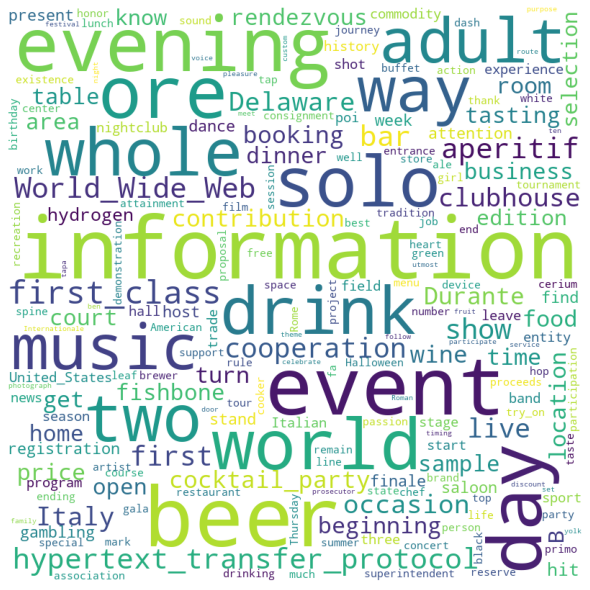

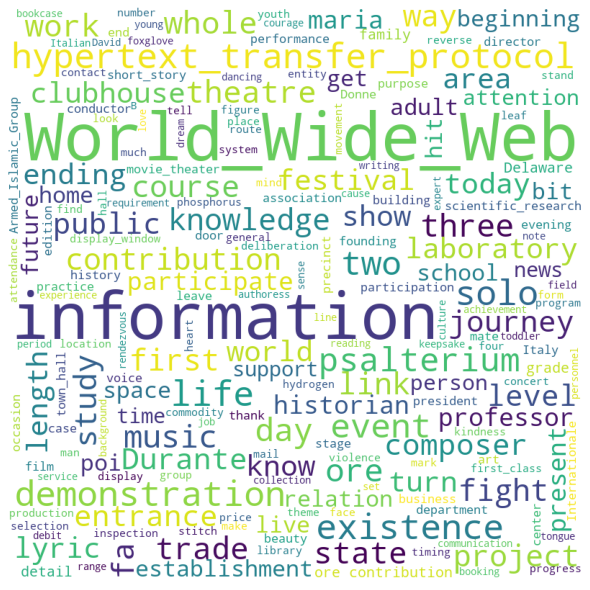

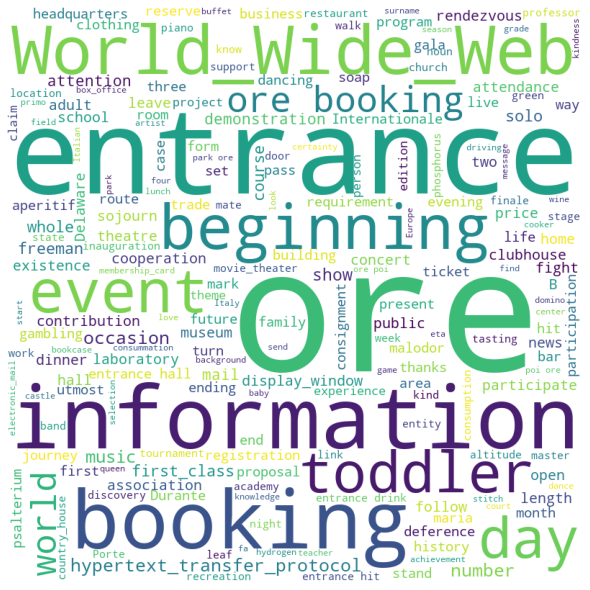

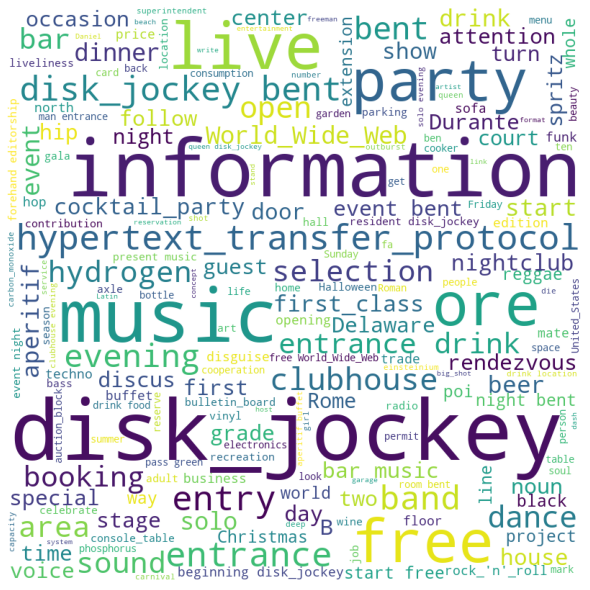

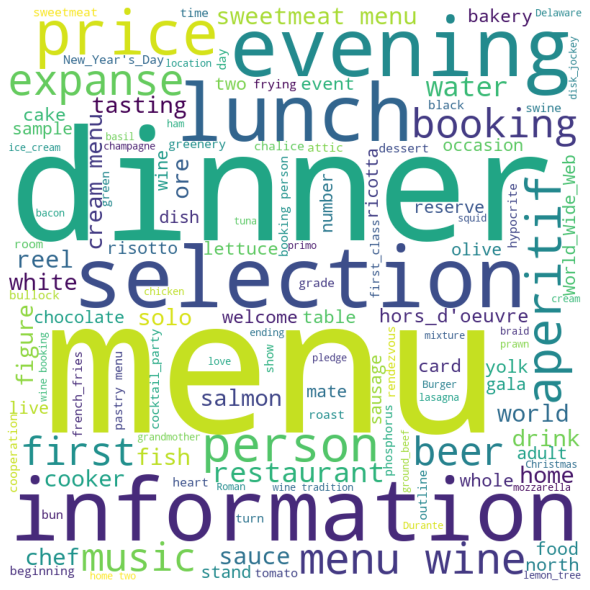

In [ ]:
labels=km.labels_
cluster_labels = np.unique(labels)
cluster_sizes = [(labels == c).sum() for c in cluster_labels]
sizes_idx = np.argsort(cluster_sizes)[::-1][:5]
X1=new_df['wordnet_desc']
# Plot dei risultati
for i, c in enumerate(cluster_labels[sizes_idx]):
    mask = (labels == c)
    descrizioni_c = np.array(X1)[mask]
    text = " ".join(descrizioni_c)
    
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwordsTotali, 
                min_font_size = 10).generate(text)

    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)

##CNN

In [124]:
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

def content_based_recommendation(event_index, content_matrix, num_recommendations):
    similarity = np.zeros(content_matrix.shape[0])
    for i in range(len(similarity)):
        similarity[i] = cosine_similarity(content_matrix[event_index], content_matrix[i])

    recommendation_indices = np.argsort(similarity)[::-1][1:num_recommendations+1]
    return recommendation_indices

In [133]:
num_events = new_df.shape[0]
num_recommendations = 5
recommendation_matrix = np.zeros((num_events, num_recommendations), dtype=int)
content_columns = ["culture", "music", "food", "fun"]
content_matrix = new_df[content_columns].values
for i in range(num_events):
    recommended_indices = content_based_recommendation(i, content_matrix, num_recommendations)
    recommendation_matrix[i, :] = recommended_indices

#np.savetxt("recommendation_matrix.csv", recommendation_matrix, delimiter=",", fmt='%d')
recommendation_matrix

array([[1453, 1345, 1981, 3765, 1035],
       [5256, 2642, 4160, 4197, 4250],
       [3418, 1909, 1865, 5326,  368],
       ...,
       [4661, 4949, 1935, 3885, 1921],
       [4444, 3702, 4211,  925,  449],
       [4482, 4126, 1612, 1251, 2068]])

'Lassociazione studentesca Unidea Medicina e lieta di invitarvi al: Corso Teorico - Pratico di Rianimazione Cardiopolmonare  che si terra il 3 Dicembre al villaggio del fanciullo, presso il centro di osteopatia 1 piano, sito nelle vicinanze del Policlinico. \n\nIl corso sara tenuto da istruttori certificati facenti parte dell\'associazione "Stayin Alive" e sara completamente gratuito. E strutturato in questo modo:\n- una parte teorica di 20/30 minuti;\n- e delle esercitazioni pratiche di 50 minuti eseguite da istruttori certificati che verranno svolte a gruppi di massimo 20 studenti per volta, in modo tale da garantire un adeguato rapporto studenti - istruttori per una corretta formazione.\nIl corso pratico verra effettuato su manichini certificati ad alta fedelta.\n\nLobiettivo di questo corso e la formazione e lacquisizione delle conoscenze e tecniche avanzate necessarie alla gestione dellemergenza respiratoria, arresto cardiaco (FV/TV senza polso con DAE, FV/TV senza polso refrattar

In [142]:
print('EVENTO PRESO IN ESAME: ')
print(new_df['text'][1000])
count = 1
for each in recommendation_matrix[1000]:
  print('EVENTO CONSIGLIATO NUMERO ' + str(count) + ': ')
  print(new_df['text'][each])
  print('\n\n')
  count = count + 1

EVENTO PRESO IN ESAME: 
Lassociazione studentesca Unidea Medicina e lieta di invitarvi al: Corso Teorico - Pratico di Rianimazione Cardiopolmonare  che si terra il 3 Dicembre al villaggio del fanciullo, presso il centro di osteopatia 1 piano, sito nelle vicinanze del Policlinico. 

Il corso sara tenuto da istruttori certificati facenti parte dell'associazione "Stayin Alive" e sara completamente gratuito. E strutturato in questo modo:
- una parte teorica di 20/30 minuti;
- e delle esercitazioni pratiche di 50 minuti eseguite da istruttori certificati che verranno svolte a gruppi di massimo 20 studenti per volta, in modo tale da garantire un adeguato rapporto studenti - istruttori per una corretta formazione.
Il corso pratico verra effettuato su manichini certificati ad alta fedelta.

Lobiettivo di questo corso e la formazione e lacquisizione delle conoscenze e tecniche avanzate necessarie alla gestione dellemergenza respiratoria, arresto cardiaco (FV/TV senza polso con DAE, FV/TV senza 